In [1]:
from dataset import generator as data_generation
from dataset import dataset
import models

import json
import numpy as np
import hiddenlayer as hl
import torch.optim as optim
import torch.nn.functional as F


from matplotlib import pyplot as plt
%matplotlib inline

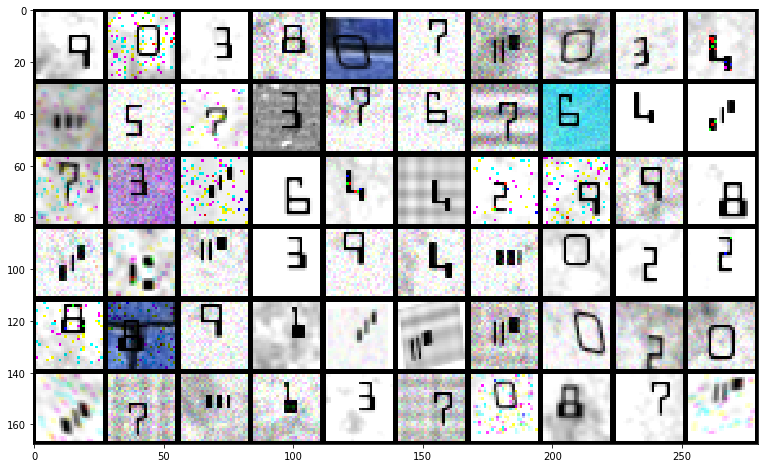

In [2]:
# You can modify the config to make the dataset 'easier' or 'harder'
dataset_config = data_generation.base_config
preview_grid = data_generation.make_preview(dataset_config)

plt.figure(figsize=[14, 8])
plt.imshow(preview_grid)

In [30]:
# If the dataset is already present setting this
# variable to True will force a total removal and recreation
remake_dataset = False
number_of_samples = 50_000
print('Generating synthetic data in directory:', dataset_config['root_directory'], '\nPlease wait')
data_generation.make_dataset(dataset_config, number_of_samples, force=remake_dataset)

Generating synthetic data in directory: ./tmp/MICRST 
Please wait
Dataset exists, add `force=True` to rebuild!


In [22]:
model = models.DeeperMicrClassifier().train()
print(model)

DeeperMicrClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=14, bias=True)
)


In [23]:
# 1 epoch - full training dataset
epochs = 15
batch_size = 128

# Gradient descend
learning_rate = 0.01
learning_momentum = 0.5
optimizer = optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=learning_momentum
)

# Visualization helpers
history = hl.History()
canvas = hl.Canvas()

# Data providers
train_loader, test_loader = dataset.make_dataset_loaders(dataset_config, batch_size=batch_size)

In [29]:
def validation_accuracy(model, data_loader):
    good_predictions = 0
    model.eval()
    for sample in data_loader:
        data = sample['image']
        target = sample['label']
        model_output = model(data)
        good_predictions += (model_output.argmax(1) == target).sum().item()
        
    accuracy = good_predictions / len(data_loader.dataset)
    
    return accuracy

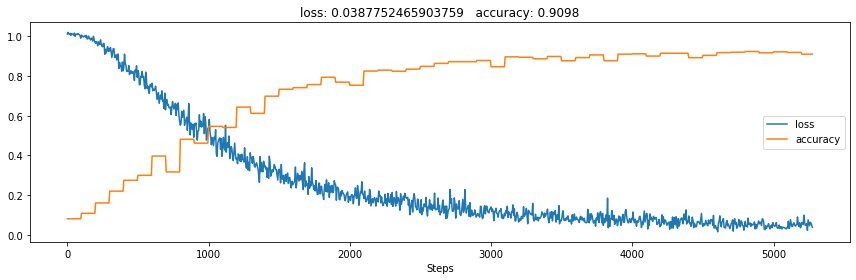

In [24]:
device = 'cpu'
step = 0
accuracy = 0
for epoch in range(1, epochs+1):
    for batch_idx, sample in enumerate(train_loader):
        data = sample['image'].to(device)
        target = sample['label'].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
                    
        if step % 100 == 0:
            accuracy = validation_accuracy(model, test_loader)
            model.train()
            
        if step % 5 == 0:
            # Normalize the loss value so the graph is more readable
            history.log(step, loss=loss/2.6, accuracy=accuracy)
            canvas.draw_plot([history['loss'], history['accuracy']])
            
        step += 1

In [26]:
validation(model, test_loader)

0.9274